In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import spatial
import math

In [7]:
num_point = 20
num_ant = 100
e = 0.15
alpha = 15
beta = 20

In [30]:
cor_point = np.random.rand(num_point,2)
distance = spatial.distance.cdist(cor_point,cor_point,metric='euclidean')
prob_city = 1/distance
prob_city[prob_city==math.inf] =0
prob_city = np.array(prob_city)

In [31]:
def roulette(prob):
    cum_prob = np.cumsum(prob)
    cum_prob = cum_prob/cum_prob[-1]
    
    sample = np.random.uniform()
    for i in range(cum_prob.shape[0]):
        if cum_prob[i] > sample:
            break
        else:
            continue
    return i

def distance_calc(rute,distance_matrix):
    distance_count = []
    for i in range(rute.shape[0]):
        count = 0
        for j in range(rute.shape[1]-1):
            count += distance_matrix[int(rute[i,j])-1,int(rute[i,j+1])-1]
        distance_count.append(count)
    return np.array(distance_count)

def pheromne_calc(pheromne,distance_cost,rute):
    for i in range(rute.shape[0]):
        dt = 1/distance_cost[i]
        for j in range(rute.shape[1]-1):
            pheromne[int(rute[i,j]-1),int(rute[i,j+1]-1)] += dt
    return pheromne


In [32]:
rute = np.ones((num_ant,num_point+1))
pheromne = 0.1*np.ones((num_ant,num_point))
cost_list = []
for iteration in range(100):
    rute[:,0] = 1

    for i in range(num_ant):
        city_left = np.arange(10)+1
        city_left = city_left[city_left!=1]
        temp_prob = prob_city.copy()
        temp_prob[:,0] = 0
        for j in range(num_point-1):
            cum_prob = np.zeros(num_point)
            temp_multi = np.zeros(num_point)

            current = int(rute[i,j]-1)
            
            r_para = np.power(pheromne[current,:],beta)
            s_para = np.power(temp_prob[current,:],alpha)

            combine = np.multiply(r_para,s_para)

            prob = combine/np.sum(combine)

            next_city = roulette(prob)+1
            rute[i,j+1] = next_city
            
            temp_prob[:,(next_city-1)] = 0
    pheromne = (1-e)*pheromne
    distance_cost = distance_calc(rute,distance)

    min_distance_index = np.argmin(distance_cost)
    min_distance_cost = distance_cost[min_distance_index]

    best_route = rute[min_distance_index]

    pheromne = pheromne_calc(pheromne,distance_cost,rute)
    cost_list.append(np.sum(distance_cost))





In [13]:
best_route

array([ 1.,  6., 15.,  2., 19., 11.,  4., 16., 18.,  5., 20.,  3., 12.,
        8., 14.,  9., 13., 10., 17.,  7.,  1.])

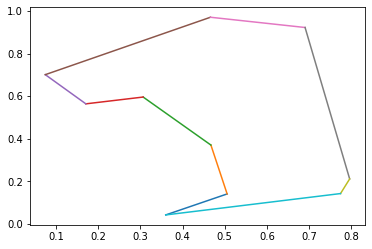

In [33]:
for i in range(len(best_route)-1):
    x1 = int(best_route[i])-1
    x2 = int(best_route[i+1])-1
    plt.plot([cor_point[x1,0],cor_point[x2,0]],[cor_point[x1,1],cor_point[x2,1]])

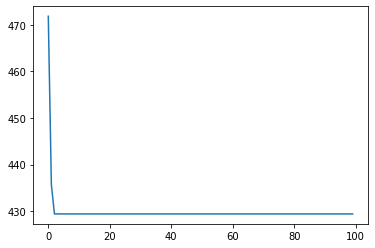

In [15]:

plt.plot(cost_list)

In [16]:
def fitness_calc(rute, distance_matrix):
    distance = distance_calc(rute,distance_matrix)
    return 1/distance
        

In [18]:
num_pop = 10
num_point = 10

rute = np.ones((num_pop,num_point+1))
for i in range(num_pop):
    temp_rute = np.arange(num_point)+1
    temp_rute = temp_rute[temp_rute != 1]
    np.random.shuffle(temp_rute)
    rute[i,1:-1] = temp_rute


fitness_matrix = fitness_calc(rute,distance)
def pop_selection(rute,fitness_matrix):
    double_gem_array = np.zeros((2,rute.shape[0],rute.shape[1]))
    for i in range(2):
        gem_list = []
        for j in range(rute.shape[0]):
            gem_list.append(roulette(fitness_matrix))
        double_gem_array[i,:,:] = rute[np.array(gem_list)]
    return double_gem_array
new_rute = pop_selection(rute,fitness_matrix)



def mate_progenitors(gem_a, gem_b):
    offspring = gem_a[0:5]

    for city in gem_b:

        if not city in offspring:
            offspring = np.concatenate((offspring,[city]))

    return offspring

def mate_population(progenitor_list):
    new_population_set = []
    for i in range(progenitor_list.shape[1]):
        prog_a, prog_b = progenitor_list[0,i,0:-1], progenitor_list[1,i,0:-1]
        offspring = mate_progenitors(prog_a, prog_b)
        new_population_set.append(offspring)
        new_temp = np.array(new_population_set)
    return np.hstack((new_temp, np.ones((new_temp.shape[0], 1))))

new_population_set = mate_population(new_rute)
new_population_set




array([[ 1., 10.,  8.,  7.,  9.,  2.,  3.,  6.,  5.,  4.,  1.],
       [ 1.,  5.,  9.,  3.,  8.,  4.,  2.,  6.,  7., 10.,  1.],
       [ 1.,  2.,  9.,  3.,  6.,  5.,  4.,  8.,  7., 10.,  1.],
       [ 1.,  4.,  2.,  8.,  6.,  3.,  7., 10.,  5.,  9.,  1.],
       [ 1., 10.,  6.,  4.,  8.,  5.,  2.,  3.,  7.,  9.,  1.],
       [ 1., 10.,  6.,  4.,  8.,  7.,  9.,  2.,  3.,  5.,  1.],
       [ 1.,  3.,  7.,  4., 10.,  5.,  9.,  8.,  6.,  2.,  1.],
       [ 1.,  2.,  4.,  8.,  9.,  3.,  7., 10.,  6.,  5.,  1.],
       [ 1.,  2.,  9.,  3.,  6., 10.,  4.,  8.,  5.,  7.,  1.],
       [ 1., 10.,  6.,  4.,  8.,  3.,  5.,  2.,  7.,  9.,  1.]])

In [22]:
def mutate_offspring(offspring):
    for q in range(int(8*0.3)):
        a = np.random.randint(0,8)
        b = np.random.randint(0,8)

        offspring[a], offspring[b] = offspring[b], offspring[a]

    return offspring
    
    
def mutate_population(new_population_set):
    mutated_pop = np.ones((10,11))
    for i in range(new_population_set.shape[0]):
        mutated_pop[i,1:-1] = mutate_offspring(new_population_set[i,1:-1])

    return mutated_pop

mutated_pop = mutate_population(new_population_set)


In [25]:
num_pop = 10
num_point = 10
cost_list = []
rute = np.ones((num_pop,num_point+1))
for i in range(num_pop):
    temp_rute = np.arange(num_point)+1
    temp_rute = temp_rute[temp_rute != 1]
    np.random.shuffle(temp_rute)
    rute[i,1:-1] = temp_rute

fitness_matrix = fitness_calc(rute,distance)

for i in range(100000):
    rute = pop_selection(rute,fitness_matrix)
    new_population_set = mate_population(rute)
    rute = mutate_population(new_population_set)

    fitness_matrix = fitness_calc(rute,distance)
    distance_cost = distance_calc(rute,distance)

    min_distance_index = np.argmin(distance_cost)
    min_distance_cost = distance_cost[min_distance_index]

    best_route = rute[min_distance_index]
    cost_list.append(np.sum(distance_cost))
    

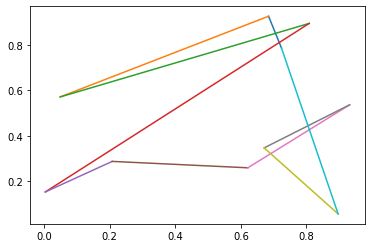

In [26]:
for i in range(len(best_route)-1):
    x1 = int(best_route[i])-1
    x2 = int(best_route[i+1])-1
    plt.plot([cor_point[x1,0],cor_point[x2,0]],[cor_point[x1,1],cor_point[x2,1]])

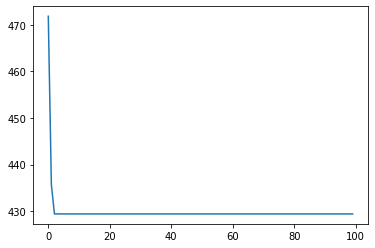

In [27]:
plt.plot(cost_list)